# CNN training for pattern recognition on Range-Doppler Heatmap crossed with Static Range-Azimuth Heatmap

In [12]:
#import tensorflow.keras
import os
from os import listdir
from os.path import isdir, join
import numpy as np
from keras import layers, models, metrics
from subprocess import check_output
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Gathering the database

In [13]:
# CNN files paths
work_dir  = os.getcwd()
filename_dop = 'all_targets_cross_0_741929408'
features_filename = filename_dop + '.npz'
model_filename = filename_dop + '.h5'

In [14]:
# Load feature set
features_set = np.load(join(work_dir, features_filename))
print('features for data set:',features_set.files)

features_set_dop = np.load(join(work_dir,features_filename))

features for data set: ['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [15]:
# Assign feature sets
x_train = features_set['x_train']
y_train = features_set['y_train']
x_val = features_set['x_val']
y_val = features_set['y_val']
x_test = features_set['x_test']
y_test = features_set['y_test']

In [16]:
# Look at tensor dimensions
print('training input shape :',x_train.shape)
print('validation input shape :',x_val.shape)
print('test input shape :',x_test.shape)

training input shape : (756, 256, 256)
validation input shape : (162, 256, 256)
test input shape : (162, 256, 256)


In [17]:
# Sample shape
NUMBER_ROWS = x_train.shape[1]
NUMBER_COlUMNS = x_train.shape[2]

In [18]:
# CNN for TF expects (batch (lote), height, width, channels)
# So we reshape the input tensors with a "color" channel of ''

x_train = x_train.reshape(int(x_train.shape[0]),
                          NUMBER_ROWS,
                          NUMBER_COlUMNS,
                          1)
x_val = x_val.reshape(int(x_val.shape[0]),
                          NUMBER_ROWS,
                          NUMBER_COlUMNS,
                          1)
x_test = x_test.reshape(int(x_test.shape[0]),
                        NUMBER_ROWS,
                        NUMBER_COlUMNS,
                        1)

print('number of training samples :',x_train.shape[0])
print('number of validation samples :',x_val.shape[0])
print('number of test samples :',x_test.shape[0])

sample_shape = x_test.shape[1:]
print('sample shape :',sample_shape)

number of training samples : 756
number of validation samples : 162
number of test samples : 162
sample shape : (256, 256, 1)


## CNN Model construction and training

### Model Construction

In [19]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()

# Convolution filters
model.add(layers.Conv2D(filters=4, kernel_size=(3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', input_shape=sample_shape, name = 'Conv2D_layer1'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name = 'Pooling_layer1'))

model.add(layers.Conv2D(filters=16, kernel_size=(3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv2D_layer2'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name = 'Pooling_layer2'))

model.add(layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv2D_layer3'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name = 'Pooling_layer3'))

# Classifier
model.add(Flatten())
model.add(Dense(128, kernel_initializer='random_normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer='random_normal', activation='relu'))
model.add(Dropout(0.5))

# Check Number of Classes Before Training
model.add(Dense(3, activation='sigmoid'))

# Display model
model.layers
model.summary()

c:\Users\Iman\Desktop\Stage\code\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_layer1 (Conv2D)          │ (None, 256, 256, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer1 (MaxPooling2D)   │ (None, 128, 128, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_layer2 (Conv2D)          │ (None, 128, 128, 16)   │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer2 (MaxPooling2D)   │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_layer3 (Conv2D)          │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer3 (MaxPooling2D)   │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,203,931 (16.04 MB)

 Trainable params: 4,203,931 (16.04 MB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [20]:
# PatientEearly Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40, restore_best_weights=True)

# Add training parameters to model
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=0.001), #SGD, RMSProp, Adam, nadam
             loss_weights=0.01,
             metrics=['accuracy'])

# Train
history_dop = model.fit(x_train,
                   y_train,
                   epochs=250,
                   batch_size=4,
                   validation_data=(x_val,y_val),
                   callbacks = [es])

Epoch 1/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.5832 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 2.4784e-05
Epoch 2/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9674 - loss: 8.8189e-04 - val_accuracy: 1.0000 - val_loss: 2.6405e-06
Epoch 3/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.9877 - loss: 3.1055e-04 - val_accuracy: 1.0000 - val_loss: 5.5328e-08
Epoch 4/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.9932 - loss: 2.9781e-04 - val_accuracy: 1.0000 - val_loss: 3.2489e-06
Epoch 5/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.9849 - loss: 4.6210e-04 - val_accuracy: 1.0000 - val_loss: 4.4688e-08
Epoch 6/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 1.0000 - loss: 1.1995e-04 - val_accuracy: 1.0000 - val_loss: 1.5379e-09
Epoch 7/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.9997 - loss: 6.5840e-05 - val_accuracy: 1.0000 - val_loss: 2.3253e-09
Epoch 8/250
189/189 ━━━━━━━━━━━

### Plotting results

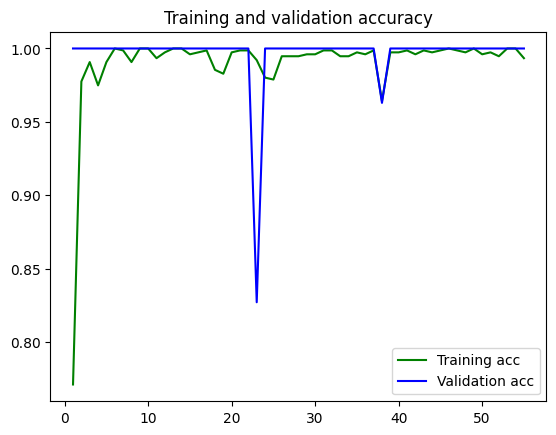

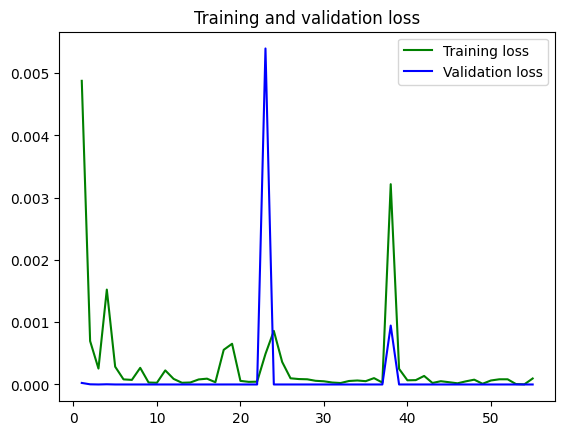

In [21]:
# Plot results
import matplotlib.pyplot as plt

acc = history_dop.history['accuracy']
val_acc = history_dop.history['val_accuracy']
loss = history_dop.history['loss']
val_loss = history_dop.history['val_loss']
#recall = history.history['recall_1']
#val_recall = history.history['val_recall_1']
#precision = history.history['precision']
#val_precision = history.history['val_precision']


epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot the training and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
# Model evaluation on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

6/6 - 0s - 58ms/step - accuracy: 1.0000 - loss: 0.0000e+00


In [23]:
# Save the model as a file
models.save_model(model, work_dir + '\\' + model_filename)

print('saved model path :',work_dir + '/' + model_filename)

saved model path : c:\Users\Iman\Desktop\Stage\code\cross_feature/all_targets_cross_0_741929408.h5


In [24]:
print(model.predict(x_test))
print(y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
[[2.38869760e-08 4.53586360e-13 1.00000000e+00]
 [1.00000000e+00 6.25298262e-01 1.65249369e-14]
 [1.06337657e-05 9.99999404e-01 1.87811511e-05]
 [2.18779874e-08 4.85302553e-13 1.00000000e+00]
 [2.19863328e-08 3.16541389e-13 1.00000000e+00]
 [1.00000000e+00 6.17445588e-01 1.86806086e-15]
 [1.00000000e+00 6.22809649e-01 7.69000037e-15]
 [2.51170320e-08 5.44363816e-13 1.00000000e+00]
 [2.27280825e-08 3.63341030e-13 1.00000000e+00]
 [2.47802721e-08 5.16643260e-13 1.00000000e+00]
 [6.52289555e-06 9.99999821e-01 4.16472585e-06]
 [4.19916120e-08 3.97476019e-12 1.00000000e+00]
 [1.00000000e+00 6.19089723e-01 3.47193786e-15]
 [2.09633390e-06 9.99999881e-01 4.11717883e-06]
 [2.72629336e-06 9.99999881e-01 6.13329757e-06]
 [1.11722311e-05 9.99999344e-01 1.94707536e-05]
 [1.00000000e+00 6.21961772e-01 5.29617430e-15]
 [9.20761522e-06 9.99999404e-01 2.02969204e-05]
 [6.41704219e-06 9.99999762e-01 5.90819354e-06]
 [2.33092283e-06 9.99999881e-01 4.19023490e-06]
 [

## Confusion matrix

In [25]:
import seaborn as sns
import tensorflow as tf


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


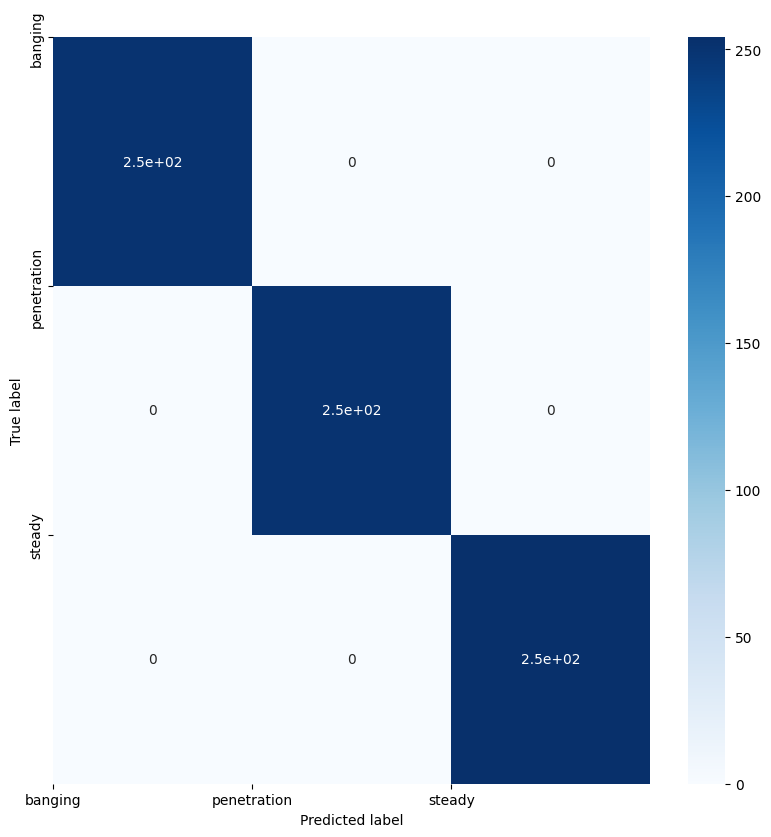

In [26]:
y_true=y_train
predict_y=model.predict(x_train)
y_pred=np.argmax(predict_y,axis=1)

classes = [0,1,2]
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float')) #/ con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks([0,1,2],['banging', 'penetration','steady'])
plt.yticks([0,1,2],['banging', 'penetration','steady'])
plt.show()

In [27]:
y_true=y_train_az
predict_y=model.predict(x_train_az)
y_pred=np.argmax(predict_y,axis=1)

classes = [0,1]
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float')) #/ con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks([0,1,2],['banging', 'penetration','steady'])
plt.yticks([0,1,2],['banging', 'penetration','steady'])
plt.show()


NameError: name 'y_train_az' is not defined

In [ ]:
# Prediction test with unclassified parameters
import scipy.interpolate as spi

# Load archive with the data to be predicted, put in shape with preparing_dataset_1folder
test_npz = np.load(os.getcwd()+'\\all_targets_0_13017_test_classes_55.npz')
test_in = test_npz['x_test']                                  

print(test_in.shape)
test_in_reshape = test_in.reshape(int(test_in.shape[0]/(NUMBER_ROWS_AZ)),                  # Resize with sample shape
                          NUMBER_ROWS_AZ,
                          NUMBER_COlUMNS_AZ,
                          1)

print('number of samples :',test_in_reshape.shape[0])
print('test samples shape :',test_in_reshape.shape[1:])

# Prediction on test sample pack
label = model.predict(test_in_reshape)
num_samples = test_in_reshape.shape[0]

# Loop throught the sample pack to display some of the predictions
for i in range (0,num_samples,10):
    print("Predicted Class for sample",i,"(0-idle, 1-presence) \n0 : ",label[i][0],"\n1 : ",label[i][1])    # Print predicted class
    sample = test_in[128*i:128*(i+1),:].reshape(
                          NUMBER_ROWS_AZ,
                          NUMBER_COlUMNS_AZ)
    range_res = 0.0436
    range_bins = sample.shape[0]
    angle_bins = sample.shape[1]
    theta = np.arcsin(np.linspace(-angle_bins / 2 + 1, angle_bins / 2 - 1, angle_bins) * (2 / angle_bins))  # Angular linear space for plotting
    range = np.linspace(0, range_bins - 1, range_bins) * range_res                                          # Range linear space for plotting
    range = np.maximum(range,0)                                                                                 # Keep only positive range value (later add range bias correction)
    range_depth = range_bins * range_res                                                         
    range_width, grid_res = range_depth/2, 64

    # Grid construction
    posX = np.outer(range, np.sin(theta))
    posY = np.outer(range, np.cos(theta))
    xlin = np.linspace(-np.floor(range_width), np.ceil(range_width), angle_bins)
    ylin = np.linspace(0, range_depth, range_bins)
    xgrid, ygrid = np.meshgrid(xlin, ylin)
    ra_grid = spi.griddata((posX.flatten(), posY.flatten()), sample.flatten(),(xgrid, ygrid), method='cubic')
    grid_init = 1
        
    hmplot = plt.contourf(xlin,ylin,sample,cmap='Spectral_r')
    plt.title(i)
    plt.show()
    #print("Expected prediction : ",expected[i],"\n")


"""     fig, subs = plt.subplots(2,2)
    for x in range(0,4,1): 
        f = sample[:,:,x]
        # read the csv file
        if (x < 2):
            subs[x][0].imshow(f, cmap='Spectral_r', interpolation='nearest', aspect='auto')
        else:
            subs[x-2][1].imshow(f, cmap='Spectral_r', interpolation='nearest', aspect='auto') """ #Doppler plotting

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\Iman\\Desktop\\Stage\\code\\all_targets_0_13017_test_classes_55.npz'